In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from numba import cuda

In [2]:
df = pd.read_csv('../data/minda-corp.csv')
df = df.iloc[::-1]
df.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
1221,23-February-2015,99.00,99.80,93.00,93.00,95.314957,2340,46,223037.0,2140.0,91.45,6.80,-6.00
1220,24-February-2015,97.50,97.50,88.35,94.85,92.268180,2819,114,260104.0,1614.0,57.25,9.15,-2.65
1219,25-February-2015,97.95,97.95,91.00,95.00,94.477243,769,36,72653.0,709.0,92.20,6.95,-2.95
1218,26-February-2015,94.50,94.50,90.25,90.90,91.546419,754,12,69026.0,754.0,100.00,4.25,-3.60
1217,27-February-2015,90.00,95.40,89.25,92.75,91.951327,226,63,20781.0,110.0,48.67,6.15,2.75


In [4]:
close_price = np.array(df["Close Price"].values)

In [5]:
time = np.arange(len(close_price))

In [7]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer_size):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size+1,shift=1,drop_remainder=True)
    data = data.flat_map(lambda window : window.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    data = data.batch(batch_size).prefetch(1)
    return data

In [8]:
split_time = 900
price_train = close_price[:split_time]
time_train = time[:split_time]

price_valid = close_price[split_time:]
time_valid = time[split_time:]


In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(price_train,window_size,batch_size,shuffle_buffer_size)


### Single Layer Network

In [8]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])

In [9]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [10]:
model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
28/28 - 0s - loss: 4222.9956
Epoch 2/100
28/28 - 0s - loss: 427.9913
Epoch 3/100
28/28 - 0s - loss: 239.3992
Epoch 4/100
28/28 - 0s - loss: 172.4183
Epoch 5/100
28/28 - 0s - loss: 130.9536
Epoch 6/100
28/28 - 0s - loss: 113.7454
Epoch 7/100
28/28 - 0s - loss: 116.5714
Epoch 8/100
28/28 - 0s - loss: 78.3569
Epoch 9/100
28/28 - 0s - loss: 77.2970
Epoch 10/100
28/28 - 0s - loss: 75.6287
Epoch 11/100
28/28 - 0s - loss: 66.9419
Epoch 12/100
28/28 - 0s - loss: 58.5004
Epoch 13/100
28/28 - 0s - loss: 73.1270
Epoch 14/100
28/28 - 0s - loss: 64.4831
Epoch 15/100
28/28 - 0s - loss: 65.6091
Epoch 16/100
28/28 - 0s - loss: 49.6201
Epoch 17/100
28/28 - 0s - loss: 55.4019
Epoch 18/100
28/28 - 0s - loss: 45.6949
Epoch 19/100
28/28 - 0s - loss: 45.7804
Epoch 20/100
28/28 - 0s - loss: 41.6666
Epoch 21/100
28/28 - 0s - loss: 42.2722
Epoch 22/100
28/28 - 0s - loss: 49.1628
Epoch 23/100
28/28 - 0s - loss: 50.8675
Epoch 24/100
28/28 - 0s - loss: 39.2079
Epoch 25/100
28/28 - 0s - loss: 39.3166
E

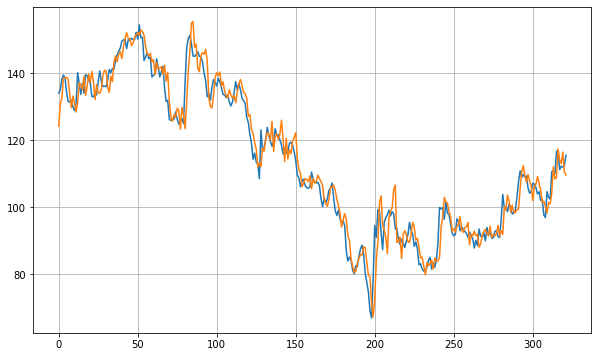

In [11]:
forecast = []

for time in range(len(close_price) - window_size):
    forecast.append(model.predict(close_price[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plt.plot(price_valid)
plt.plot(results)
plt.grid()

In [17]:
print(tf.keras.metrics.mean_absolute_error(price_valid,results).numpy())

3.3492553


In [18]:
print(tf.keras.metrics.mean_squared_error(price_valid,results).numpy())

20.328478


### Multi layer Network

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
lr_sch = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss='mse',optimizer=optimizer)
history = model.fit(dataset,epochs = 100,callbacks=[lr_sch],verbose=0)

(1e-08, 0.001, 0.0, 300.0)

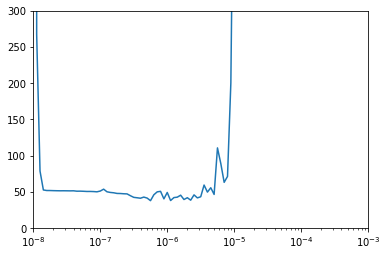

In [12]:
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [14]:
history.history['loss'].index(min(history.history['loss']))

35

In [15]:
lrs[35]

5.623413251903491e-07

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
optimizer = tf.keras.optimizers.SGD(lr=5.623413251903491e-07,momentum=0.9)
model.compile(loss='mse',optimizer=optimizer)
history = model.fit(dataset,epochs = 100,verbose=2)

Epoch 1/100
28/28 - 0s - loss: 14947.5537
Epoch 2/100
28/28 - 0s - loss: 320.3186
Epoch 3/100
28/28 - 0s - loss: 75.9431
Epoch 4/100
28/28 - 0s - loss: 58.3583
Epoch 5/100
28/28 - 0s - loss: 54.9096
Epoch 6/100
28/28 - 0s - loss: 53.7701
Epoch 7/100
28/28 - 0s - loss: 52.5885
Epoch 8/100
28/28 - 0s - loss: 57.4169
Epoch 9/100
28/28 - 0s - loss: 50.2000
Epoch 10/100
28/28 - 0s - loss: 53.4286
Epoch 11/100
28/28 - 0s - loss: 51.5596
Epoch 12/100
28/28 - 0s - loss: 48.8022
Epoch 13/100
28/28 - 0s - loss: 48.6080
Epoch 14/100
28/28 - 0s - loss: 44.9553
Epoch 15/100
28/28 - 0s - loss: 51.9556
Epoch 16/100
28/28 - 0s - loss: 51.5488
Epoch 17/100
28/28 - 0s - loss: 45.8217
Epoch 18/100
28/28 - 0s - loss: 44.9789
Epoch 19/100
28/28 - 0s - loss: 41.7931
Epoch 20/100
28/28 - 0s - loss: 41.5721
Epoch 21/100
28/28 - 0s - loss: 40.6126
Epoch 22/100
28/28 - 0s - loss: 38.5029
Epoch 23/100
28/28 - 0s - loss: 38.6386
Epoch 24/100
28/28 - 0s - loss: 39.6608
Epoch 25/100
28/28 - 0s - loss: 45.2567
Epoch

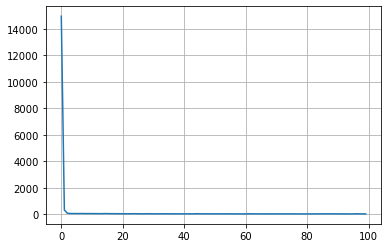

In [12]:
plt.plot(history.history['loss'])
plt.grid()

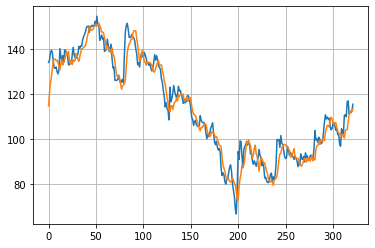

In [14]:
forecast = []

for time in range(len(close_price) - window_size):
    forecast.append(model.predict(close_price[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size : ]
results = np.array(forecast)[:,0,0]

plt.plot(price_valid)
plt.plot(results)
plt.grid()

In [15]:
tf.keras.metrics.mean_absolute_error(price_valid,results).numpy()

3.7330115

In [11]:
cuda.close()